In [1]:
import numpy as np
import pandas as pd
import os

# Print the input folder
directory = r'C:\\Users\\Dell\\Data Science\\'
print("INPUT FOLDER:")
for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load MADRS held in score
file_path = os.path.join(directory, "scores.csv")
scores = pd.read_csv(file_path)

MADRS1 = np.array(scores["madrs1"])
MADRS2 = np.array(scores["madrs2"])
MADRS = np.vstack((MADRS1, MADRS2))

# Discard NaN (healthy subjects), keep the average of only condition subjects for convenience
nanvals = np.where(np.isnan(MADRS))
MADRS = np.delete(MADRS, nanvals[1], 1)

MADRS = np.mean(MADRS, axis=0)
print("Mean MADRS Scores:", MADRS)

scores.head()


INPUT FOLDER:
C:\\Users\\Dell\\Data Science\\First file.ipynb
C:\\Users\\Dell\\Data Science\\Mean activity of condition group.jpg
C:\\Users\\Dell\\Data Science\\Mean activity of control group.jpg
C:\\Users\\Dell\\Data Science\\scores.csv
C:\\Users\\Dell\\Data Science\\Second file.ipynb
C:\\Users\\Dell\\Data Science\\.ipynb_checkpoints\First file-checkpoint.ipynb
C:\\Users\\Dell\\Data Science\\.ipynb_checkpoints\Second file-checkpoint.ipynb
C:\\Users\\Dell\\Data Science\\condition\condition_1.csv
C:\\Users\\Dell\\Data Science\\condition\condition_10.csv
C:\\Users\\Dell\\Data Science\\condition\condition_11.csv
C:\\Users\\Dell\\Data Science\\condition\condition_12.csv
C:\\Users\\Dell\\Data Science\\condition\condition_13.csv
C:\\Users\\Dell\\Data Science\\condition\condition_14.csv
C:\\Users\\Dell\\Data Science\\condition\condition_15.csv
C:\\Users\\Dell\\Data Science\\condition\condition_16.csv
C:\\Users\\Dell\\Data Science\\condition\condition_17.csv
C:\\Users\\Dell\\Data Science\\cond

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [5]:
def convert_timestamps(timestamps): #  panda series ==to==> [Hours][Minutes] (list)
    from datetime import datetime
    HH_MM = [0, 0]*len(timestamps)   
    for i in range(len(timestamps)):
        t = timestamps.iloc[i][0]
        d = datetime.strptime(t, '%Y-%m-%d %H:%M:%S')       
        h,m = d.hour, d.minute
        HH_MM[i] = h,m        
    return HH_MM


def read_subject(cohort,subj): # read subject data from the folder; 
    filename = cohort+"_"+str(subj)+".csv";
    file = pd.read_csv(r'C:\\Users\\Dell\\Data Science'+cohort+"/"+filename,header=0)
    timestamps = file.iloc[:,[0]]
    dates = file.iloc[:,[1]]
    activity = file.iloc[:,[2]]     
    HH_MM = convert_timestamps(timestamps)
    
    # convert dataframe to array
    activity = np.array(activity)
    activity = activity.reshape(-1)

    return HH_MM, activity

def rearrange_in_days(HH_MM, activity): # stacks days of recorded activity
    midnights = idx(HH_MM,(0,0))    
    for i in range(0,len(midnights)-1):
        day_i = activity[midnights[i]:(midnights[i+1]-1)]
        if i==0: rec = day_i
        elif len(day_i)==minutesinaday: rec = np.vstack((rec,day_i))
    return rec

def gather_data(cohort,subj): # bridge function: use rearrange_in_days and read_subject together
    HH_MM,activity = read_subject(cohort,subj)
    days = rearrange_in_days(HH_MM, activity) 
    return days

def idx(l, target): # returns the pos. of every occurence of 'target'
    output = [];
    for i in range(len(l)):
        if l[i]==target:
            output.append(i)
    return output

def get_subj_index(cohort,subj,I): # helps us finding specific subjects' data in a structured array
    if cohort == "condition":
        subj = subj+32  
    i = np.where(I == subj)
    istart = i[0][0]
    iend = i[0][-1]
    return (istart, iend)

def visualize_data(x,y,style,col = 'black',T ='', l='',xl='', yl='',xlimit=None):
    import matplotlib.pyplot as plt
    if style =='plot':
        plt.plot(x,y,color = col, label = l)
    if style =='scatter':
        plt.scatter(x,y,color = col, label = l)  
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(T)
    if not(xlimit is None):
        plt.xlim((xlimit[0],xlimit[1]))
    return None  
    
def feature_extract(X):
    featurevec = []
    t = np.linspace(0,360-(360/1439),1439)
    for day in X:
        f1 = np.mean(day)
        f2 = np.std(day)
        f3 = np.max(day)
        f,f4,f5,f6= cosinor(t,day)
        f8 = np.sum(day)**2
        featurevec.append([f1,f2,f3,f5,f6])
        
    X_feat = np.array(featurevec)
    return X_feat

In [3]:
Ncontr = 32 # number of control subjects
Ncond  = 23 # number of condition subjects
minutesinaday = 1439 # from 00:00 to 23:59 there are 1439 minutes

counter = 1
for subj in range(1,Ncontr):
    cohort = "control"
    
    days = gather_data(cohort,subj)
    ndays = days.shape[0];
    label = np.zeros(ndays,dtype = int)
    subj_id= np.ones(ndays,dtype = int) * counter
    counter=counter+1
    
    if subj == 1: # array init
        Y = label 
        X = days
        ID= subj_id 
        
    else:         # array expansion
        X = np.vstack((X,days))
        Y = np.hstack((Y,label))
        ID= np.hstack((ID,subj_id))
        
    
for subj in range(1, Ncond):
    cohort = "condition"
    
    days = gather_data(cohort,subj)
    ndays = days.shape[0];
    label = np.ones(ndays,dtype = int)
    subj_id= np.ones(ndays,dtype = int) * counter
    counter=counter+1
    
    X = np.vstack((X,days))
    Y = np.hstack((Y,label))
    ID= np.hstack((ID,subj_id))
    
print("Actigraphy data structure > X:", X.shape,"(n. of days x minutes in a day)")
print("Labels > Y:", Y.shape,"(n. of days)")
print("subj. id stored in ID :\n", np.unique(ID))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\\\Users\\\\Dell\\\\Data Sciencecontrol/control_1.csv'

there are approximately  213  suspiciously low-activity days


Text(0.5, 0.98, 'suspicious recordings')

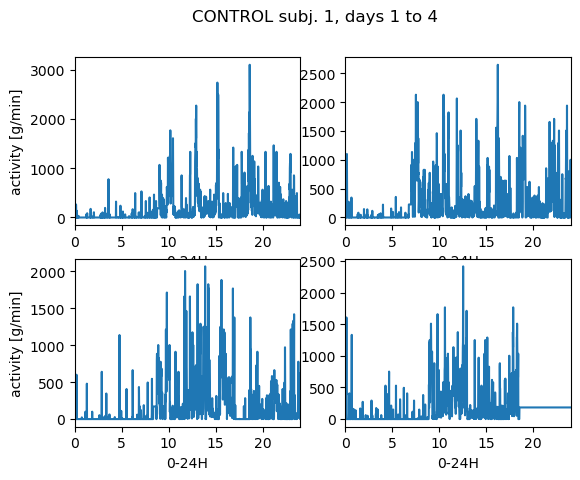

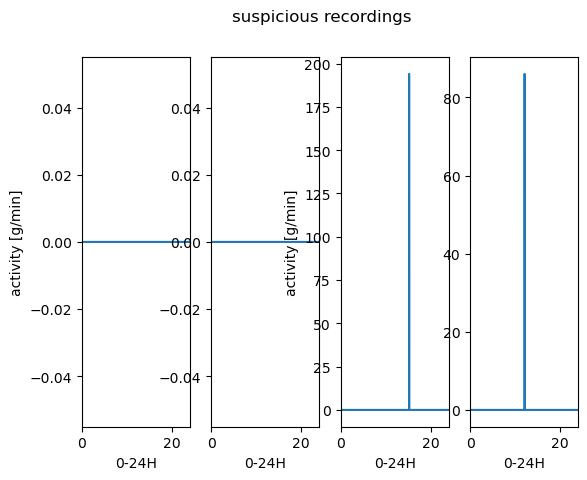

In [6]:
import matplotlib.pyplot as plt  
ax = np.arange(0, 24+0.0167, 0.0167) # X-Axis to plot 0-24H

# HOW DATA LOOKS LIKE? 
plt.figure(0)
plt.subplot(2,2,1)
plt.plot(ax, X[0])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,2)
plt.plot(ax, X[1])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,3)
plt.plot(ax, X[2])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,4)
plt.plot(ax, X[3])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.suptitle("CONTROL subj. 1, days 1 to 4")

# ARE THERE ANY INCONSISTENCIES?
threshold = 25 
X_mean = np.mean(X,axis=1)
sus = np.where(X_mean<threshold)
sus = sus[0]
print("there are approximately ",len(sus)," suspiciously low-activity days")
plt.figure()
plt.subplot(1,4,1)
plt.plot(ax,X[sus[0]]),plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(1,4,2)
plt.plot(ax,X[sus[1]]), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(1,4,3)
plt.plot(ax,X[sus[2]]),plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(1,4,4)
plt.plot(ax,X[sus[3]]), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.suptitle("suspicious recordings")

In [4]:
print("original dataset size: ",X.shape)
X = np.delete(X,sus,axis=0)
Y = np.delete(Y,sus,axis=0)
ID= np.delete(ID,sus,axis=0)
print(" cleaned dataset size: ",X.shape)

# input: time series ==> output: smoothed time series
def smooth(day,win):
    from scipy import signal
    import numpy as np
    
    L = win #L-point Moving Average filter
    b = (np.ones(L))/L #numerator co-effs of filter transfer function
    a = np.ones(1)   #denominator co-effs of filter transfer function
    x = day 
    y = signal.lfilter(b,a,x) #filter output using lfilter function
    return y

# 20-Minutes Moving Average Filter
window = 20
for i in range(0,X.shape[0]):
    day = X[i]
    smoothed_day = smooth(day,window)
    
    if i==0: 
        X_smooth = smoothed_day
    else: 
        X_smooth = np.vstack((X_smooth,smoothed_day))

    
plt.figure()
plt.subplot(2,2,1)
plt.plot(ax, X_smooth[0])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,2)
plt.plot(ax, X_smooth[1])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,3)
plt.plot(ax, X_smooth[2])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,4)
plt.plot(ax, X_smooth[3])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.suptitle("smoothed CONTROL subj. 1, days 1 to 4")

plt.figure()
plt.title("20-minutes moving average")
plt.plot(ax,X[0],color='r',label="raw"),plt.ylabel("activity [g/min]")
plt.plot(ax,X_smooth[0],color='b',label="smoothed"),plt.xlabel("0-24H"),plt.xlim(0,24)
plt.legend()
plt.show()

NameError: name 'X' is not defined

In [8]:
# cosinor function: doing the fit ourselves
def cosinor(t,y):  
    t = t/360

    w=np.pi*2
    n=len(t)

    x = np.cos(w*t)
    z = np.sin(w*t)

    NE = sym.Matrix(   [[n,         np.sum(x),    np.sum(z),    np.sum(y)  ],
                    [np.sum(x), np.sum(x**2), np.sum(x*z),  np.sum(x*y)],
                    [np.sum(z), np.sum(x*z),  np.sum(z**2), np.sum(z*y)]]   )
    RNE = NE.rref()
    RNE = np.array(RNE[0])

    M = float(RNE[0][3])
    beta = float(RNE[1][3])
    gamma = float(RNE[2][3])

    import math
    Amp = math.sqrt((beta**2 + gamma**2))
    theta = np.arctan2(np.abs(gamma),np.abs(beta))

    # Calculate acrophase (phi) and convert from radians to degrees
    a = np.sign(beta);
    b = np.sign(gamma);
    if (a == 1 or a == 0) and b == 1:
        phi = -theta;
    elif a == -1 and (b == 1 or b == 0):
        phi = -pi + theta;
    elif (a == -1 or a == 0) and b == -1:
        phi = -pi - theta;
    elif a == 1 and (b == -1 or b == 0):
        phi = -2*pi + theta
    
    phi = float(phi)
    
    f = M + Amp*np.cos(w*t+phi)
    
    return f,M,Amp,phi
    plt.figure()
    visualize_data(t,f,style="plot",col="red")
    visualize_data(t,y,style="scatter",col="blue")
    plt.show()

control size:  (463, 1439)
condition size:  (297, 1439)


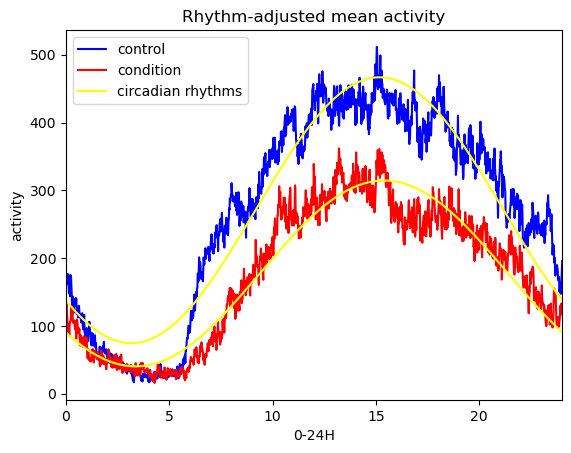

In [9]:
# get index of last control subj to separate the groups
istart,iend = get_subj_index("control",Ncontr,ID)

# rhythm-adjusted control mean
control = X[:iend]
print("control size: ",control.shape)
control_mean = np.mean(control,axis=0)

# rhythm-adjusted condition mean
condition = X[iend+1:]
print("condition size: ",condition.shape)
condition_mean = np.mean(condition,axis=0)

# Circaian Rhythms
t = np.linspace(0,360-(360/1439),1439)
import sympy as sym
from sympy import *
control_circadian_rh,control_MESOR,Amp,control_acro = cosinor(t,control_mean)
condition_circadian_rh,conition_MESOR,Amp,condition_acro = cosinor(t,condition_mean)

plt.figure()
plt.plot(ax,control_mean, color='b', label="control")
plt.plot(ax,condition_mean,color='r',label="condition")
plt.xlabel("0-24H"),plt.ylabel("activity  [g/min]"),plt.xlim(0,24)
visualize_data(ax,control_circadian_rh,style="plot",col="yellow",l='circadian rhythms')
visualize_data(ax,condition_circadian_rh,style="plot",col="yellow",T="Rhythm-adjusted mean activity",xl='0-24H',yl='activity')

plt.legend()

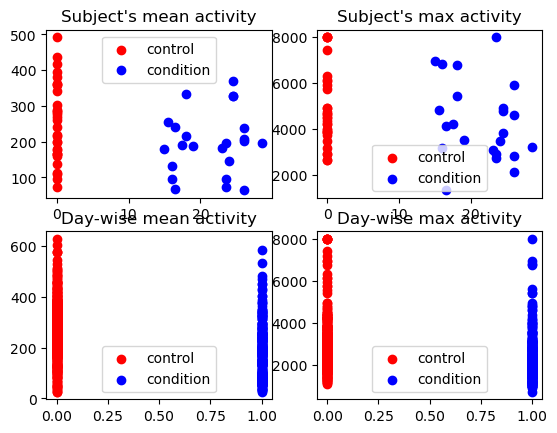

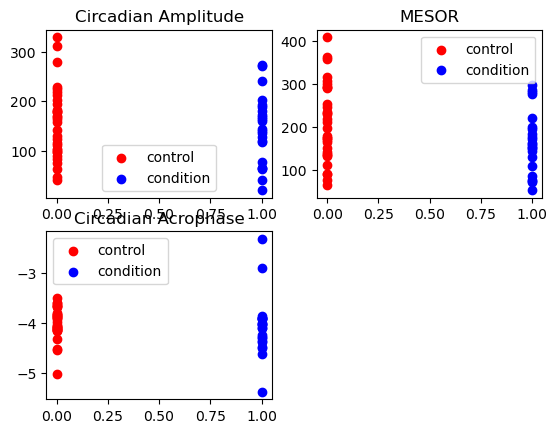

In [10]:
# subject-wise mean, max activity and circadian rhythm
for subj in range(0,Ncontr):
    subj_data = gather_data("control",subj+1)
    
    # we fit circadian rhythm on subject 24H activity rhythm
    rhythm = np.mean(subj_data,axis=0)
    
    # take only day time hours (from 5am)
    begin = 60* 5 
    
    subj_data = np.delete(subj_data, range(0,begin),axis = 1)
    subj_mean = np.mean(subj_data)
    subj_max  = np.max(subj_data)
    f,subj_MESOR,subj_amp,subj_acrophase = cosinor(t,rhythm)
    
    if subj == 0:
        control_subj_mean = subj_mean
        control_subj_max  = np.array(subj_max)
        control_acro = np.array(subj_acrophase)
        control_amp  = np.array(subj_amp)
        control_MESOR= np.array(subj_MESOR)
    else:
        control_subj_mean = np.hstack((control_subj_mean, subj_mean))
        control_subj_max = np.hstack((control_subj_max,subj_max))
        control_acro = np.hstack((control_acro, subj_acrophase))
        control_amp  = np.hstack((control_amp,subj_amp))
        control_MESOR= np.hstack((control_MESOR,subj_MESOR))
        
axe = np.zeros(Ncontr, dtype=float) 
    
for subj in range(0,Ncond):
    subj_data = gather_data("condition",subj+1)
    # we fit circadian rhythm on subject 24H activity rhythm
    rhythm = np.mean(subj_data,axis=0)
    
    # take only day time hours (from 5am)
    begin = 60* 5 

    
    subj_data = np.delete(subj_data, range(0,begin),axis = 1)
    subj_mean = np.mean(subj_data)
    subj_max  = np.max(subj_data)
    f,subj_MESOR,subj_amp,subj_acrophase = cosinor(t,rhythm)
    
    if subj == 0:
        condition_subj_mean = subj_mean
        condition_subj_max  = np.array(subj_max)
        condition_acro = np.array(subj_acrophase)
        condition_amp  = np.array(subj_amp)
        condition_MESOR= np.array(subj_MESOR)
    else:
        condition_subj_mean = np.hstack((condition_subj_mean, subj_mean))
        condition_subj_max = np.hstack((condition_subj_max,subj_max))
        condition_acro = np.hstack((condition_acro, subj_acrophase))
        condition_amp  = np.hstack((condition_amp,subj_amp))
        condition_MESOR= np.hstack((condition_MESOR,subj_MESOR))
        
# day-wise max activity
control_day_max = np.amax(control,axis=1)
condition_day_max=np.amax(condition,axis=1)

# day-wise mean activity
control_day_mean   = np.mean(control,axis = 1)
condition_day_mean = np.mean(condition,axis = 1)

plt.figure()
plt.subplot(2,2,1)
visualize_data(np.zeros(Ncontr, dtype=float), control_subj_mean, style="scatter",col="red",T="",l="control")
visualize_data(MADRS, condition_subj_mean,style="scatter",col="blue",T="Subject's mean activity",l="condition")
plt.legend()

plt.subplot(2,2,2)
visualize_data(np.zeros(Ncontr, dtype=float), control_subj_max, style="scatter",col="red",T="",l="control")
visualize_data(MADRS, condition_subj_max,style="scatter",col="blue",T="Subject's max activity",l="condition")
plt.legend()

plt.subplot(2,2,4)
visualize_data(np.zeros(len(control_day_max)), control_day_max, style="scatter",col="red",T="",l="control")
visualize_data(np.ones(len(condition_day_max)), condition_day_max,style="scatter",col="blue",T="Day-wise max activity",l="condition")
plt.legend()
               
plt.subplot(2,2,3)
visualize_data(np.zeros(len(control_day_mean)), control_day_mean, style="scatter",col="red",T="",l="control")
visualize_data(np.ones(len(condition_day_mean)), condition_day_mean,style="scatter",col="blue",T="Day-wise mean activity",l="condition")
plt.legend()
plt.show()

plt.figure()
plt.subplot(2,2,1)
visualize_data(np.zeros(len(control_amp)), control_amp, style="scatter",col="red",T="",l="control")
visualize_data(np.ones(len(condition_amp)), condition_amp,style="scatter",col="blue",T="Circadian Amplitude",l="condition")
plt.legend()
plt.subplot(2,2,2)
visualize_data(np.zeros(len(control_MESOR)), control_MESOR, style="scatter",col="red",T="",l="control")
visualize_data(np.ones(len(condition_MESOR)), condition_MESOR,style="scatter",col="blue",T="MESOR",l="condition")
plt.legend()
plt.subplot(2,2,3)
visualize_data(np.zeros(len(control_acro)), control_acro, style="scatter",col="red",T="",l="control")
visualize_data(np.ones(len(condition_acro)), condition_acro,style="scatter",col="blue",T="Circadian Acrophase",l="condition")
plt.legend()
plt.show()

In [11]:
import scipy.stats as stats
th = 0.05

# mean activity
print("\n === day-wise mean ===")
t,p =stats.ranksums(control_day_mean, condition_day_mean)
if p>th:
    print("null hypothesis accepted: groups' means are statistically equal")
else:
    print("null hypothesis rejected: groups' means are statistically different")
print("K = ",t,"; p-value: ",p)

print("\n === sbubject-wise mean ===")  
t,p =stats.ranksums(control_subj_mean, condition_subj_mean)
if p>th:
    print("null hypothesis accepted: groups' means are statistically equal")
else:
    print("null hypothesis rejected: groups' means are statistically different")
print("K = ",t,"; p-value: ",p)
# max activity
print("\n === day-wise max ===")  
t,p =stats.ranksums(control_day_max, condition_day_max)
if p>th:
    print("null hypothesis accepted: groups' means are statistically equal")
else:
    print("null hypothesis rejected: groups' means are statistically different")
print("K = ",t,"; p-value: ",p)

print("\n === subject-wise max ===")  
t,p =stats.ranksums(control_subj_max, condition_subj_max)
if p>th:
    print("null hypothesis accepted: groups' means are statistically equal")
else:
    print("null hypothesis rejected: groups' means are statistically different")
print("K = ",t,"; p-value: ",p)

print("\n === subject-wise Acrophase ===")
t,p =stats.ranksums(control_acro, condition_acro)
if p>th:
    print("null hypothesis accepted: groups' means are statistically equal")
else:
    print("null hypothesis rejected: groups' means are statistically different")
print("K = ",t,"; p-value: ",p)

print("\n === subject-wise Cycle Amplitude ===")
t,p =stats.ranksums(control_amp, condition_amp)
if p>th:
    print("null hypothesis accepted: groups' means are statistically equal")
else:
    print("null hypothesis rejected: groups' means are statistically different")
print("K = ",t,"; p-value: ",p)


 === day-wise mean ===
null hypothesis rejected: groups' means are statistically different
K =  11.416511436157998 ; p-value:  3.45839123198799e-30

 === sbubject-wise mean ===
null hypothesis accepted: groups' means are statistically equal
K =  1.8257507177130765 ; p-value:  0.06788781975847816

 === day-wise max ===
null hypothesis rejected: groups' means are statistically different
K =  8.11314426693139 ; p-value:  4.93264501377814e-16

 === subject-wise max ===
null hypothesis accepted: groups' means are statistically equal
K =  1.1688217211527638 ; p-value:  0.2424754670478474

 === subject-wise Acrophase ===
null hypothesis accepted: groups' means are statistically equal
K =  1.5868674462365993 ; p-value:  0.11254266924324113

 === subject-wise Cycle Amplitude ===
null hypothesis accepted: groups' means are statistically equal
K =  0.49482963377270295 ; p-value:  0.6207203844344442


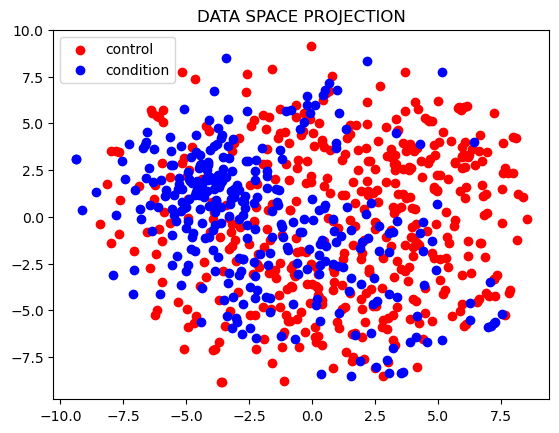

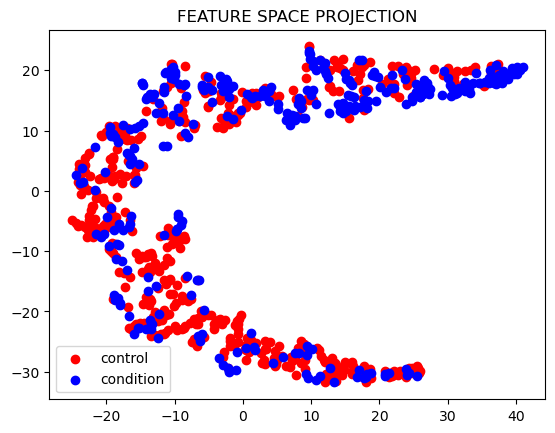

[[102  13]
 [ 40  36]]
              precision    recall  f1-score   support

           0       0.72      0.89      0.79       115
           1       0.73      0.47      0.58        76

    accuracy                           0.72       191
   macro avg       0.73      0.68      0.68       191
weighted avg       0.72      0.72      0.71       191



In [12]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns

ind = (np.where(Y==0))
ind = len(ind[0])
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(X)
plt.figure()
visualize_data(X_embedded[:ind-1,0],X_embedded[:ind-1,1],style="scatter",col="red",T="",l="control")
visualize_data(X_embedded[ind:,0],X_embedded[ind:,1],style="scatter",col="blue",T="DATA SPACE PROJECTION",l="condition")
plt.legend()
plt.show()
X_features = feature_extract(X)

plt.figure()
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(X_features)
visualize_data(X_embedded[:ind-1,0],X_embedded[:ind-1,1],style="scatter",col="red",T="",l="control")
visualize_data(X_embedded[ind:,0],X_embedded[ind:,1],style="scatter",col="blue",T="FEATURE SPACE PROJECTION",l="condition")
plt.legend()
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X_features,Y,random_state=100)

from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

# cross validate the model
from sklearn.model_selection import cross_val_predict
y_pred =  cross_val_predict(svclassifier, X_test, y_test, cv=10)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [13]:
individual_pred = np.zeros(Ncontr+Ncond)
day_prediction = cross_val_predict(svclassifier, X_features, Y, cv=10)

for subj in (np.unique(ID)):
    subj_rec_idx = idx(ID,subj)   
    prediction = day_prediction[subj_rec_idx]
    individual_pred[subj] = np.median(prediction)

Y_test = np.ones(Ncontr+Ncond)
Y_test[:(Ncontr-1)]= 0;

print(classification_report(Y_test,individual_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.90      0.77        31
         1.0       0.77      0.42      0.54        24

    accuracy                           0.69        55
   macro avg       0.72      0.66      0.65        55
weighted avg       0.71      0.69      0.67        55

